# 1. Import libraries

In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 2. Exploring Raw Data

In [6]:
df = pd.read_csv('weather_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88104 entries, 0 to 88103
Data columns (total 35 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   time_epoch      88104 non-null  int64  
 1   time            88104 non-null  object 
 2   temp_c          88104 non-null  float64
 3   temp_f          88104 non-null  float64
 4   is_day          88104 non-null  int64  
 5   condition       88104 non-null  object 
 6   wind_mph        88104 non-null  float64
 7   wind_kph        88104 non-null  float64
 8   wind_degree     88104 non-null  int64  
 9   wind_dir        88104 non-null  object 
 10  pressure_mb     88104 non-null  int64  
 11  pressure_in     88104 non-null  float64
 12  precip_mm       88104 non-null  float64
 13  precip_in       88104 non-null  float64
 14  snow_cm         88104 non-null  float64
 15  humidity        88104 non-null  int64  
 16  cloud           88104 non-null  int64  
 17  feelslike_c     88104 non-null 

In [7]:
df.head()

,time_epoch,time,temp_c,temp_f,is_day,condition,wind_mph,wind_kph,wind_degree,wind_dir,...,will_it_rain,chance_of_rain,will_it_snow,chance_of_snow,vis_km,vis_miles,gust_mph,gust_kph,uv,city
0,1716397200,5/23/2024 0:00,25.8,78.5,0,Patchy rain possible,6.0,9.7,151,SSE,...,1,100,0,0,10.0,6,11.1,17.8,0,Hanoi
1,1716400800,5/23/2024 1:00,25.5,78.0,0,Moderate or heavy rain shower,4.9,7.9,151,SSE,...,1,100,0,0,9.0,5,9.5,15.3,0,Hanoi
2,1716404400,5/23/2024 2:00,25.6,78.1,0,Moderate or heavy rain shower,3.6,5.8,152,SSE,...,1,100,0,0,9.0,5,6.9,11.2,0,Hanoi
3,1716408000,5/23/2024 3:00,25.6,78.1,0,Cloudy,2.0,3.2,138,SE,...,0,0,0,0,9.0,5,6.3,10.1,0,Hanoi
4,1716411600,5/23/2024 4:00,25.4,77.8,0,Moderate rain at times,1.6,2.5,85,E,...,1,100,0,0,10.0,6,5.4,8.6,0,Hanoi


In [10]:
class_counts = df['condition'].value_counts()
class_counts

condition
Clear                                  20511
Sunny                                  19943
Partly cloudy                          13357
Cloudy                                  9187
Patchy rain possible                    9029
Overcast                                9019
Moderate or heavy rain shower           3031
Moderate rain at times                  2066
Heavy rain at times                     1168
Light freezing rain                      352
Light rain shower                        123
Patchy moderate snow                      57
Moderate snow                             47
Thundery outbreaks possible               42
Light drizzle                             35
Light rain                                31
Fog                                       20
Moderate or heavy snow showers            18
Patchy light drizzle                      17
Mist                                      15
Moderate rain                             11
Freezing fog                               9


C:\Users\ASUS\AppData\Local\Temp\ipykernel_25344\3427596702.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=class_percentages.values, y=class_percentages.index, palette="Blues")


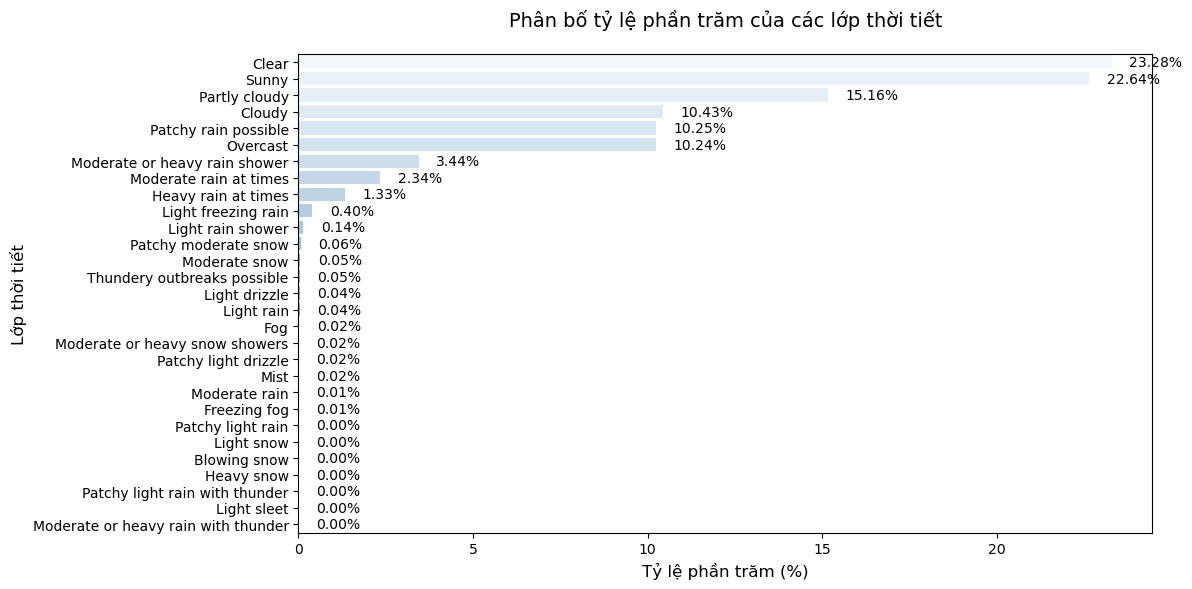

In [ ]:
total_samples = len(df)

class_percentages = (class_counts / total_samples * 100)

plt.figure(figsize=(12, 6))
bars = sns.barplot(x=class_percentages.values, y=class_percentages.index, palette="Blues")

# Thêm tỷ lệ phần trăm ở đầu mỗi cột
for bar in bars.patches:
    width = bar.get_width()
    plt.text(width + 0.5, bar.get_y() + bar.get_height()/2, f'{width:.2f}%', 
             ha='left', va='center', fontsize=10, color='black')

# Tùy chỉnh giao diện
plt.xlabel('Tỷ lệ phần trăm (%)', fontsize=12)
plt.ylabel('Lớp thời tiết', fontsize=12)
plt.title('Phân bố tỷ lệ phần trăm của các lớp thời tiết', fontsize=14, pad=20)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

# Hiển thị biểu đồ
plt.show()

# 3. Relabelling Data

In [33]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt

# Đọc dữ liệu thô
df = pd.read_csv("weather_data.csv")

# Lấy danh sách các điều kiện thời tiết gốc từ cột condition
conditions = df['condition'].unique().tolist()
print("Danh sách điều kiện thời tiết gốc:", conditions)

# Tải mô hình BERT (sentence-transformers)
# Sử dụng mô hình 'all-MiniLM-L6-v2' (nhẹ, nhanh, và hiệu quả cho nhúng cụm từ)
model = SentenceTransformer('all-MiniLM-L6-v2')

# Nhúng các điều kiện thời tiết thành vector
condition_vectors = model.encode(conditions)

similarity_matrix = cosine_similarity(condition_vectors)


similarity_df = pd.DataFrame(similarity_matrix, index=conditions, columns=conditions)


plt.figure(figsize=(12, 10))
sns.heatmap(similarity_df, annot=False, cmap="coolwarm", vmin=-1, vmax=1, center=0)
plt.title("Ma Trận Tương Đồng Ngữ Nghĩa Giữa Các Điều Kiện Thời Tiết (BERT)", fontsize=14, pad=20)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()

# Hiển thị biểu đồ
plt.show()

# In ma trận tương đồng dưới dạng số (dễ đọc hơn cho ma trận lớn)
print("\nMa trận tương đồng ngữ nghĩa (dạng số):")
print(similarity_df.round(2))

ModuleNotFoundError: No module named 'sentence_transformers'